<a href="https://colab.research.google.com/github/chen70335/cirrhosis_prediction/blob/main/kaggle_cirrhosis_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
import pandas as pd


drive.mount('/content/MyDrive')

train_csv = pd.read_csv('/content/MyDrive/MyDrive/Colab Notebooks/kaggle/train.csv')
test_csv = pd.read_csv('/content/MyDrive/MyDrive/Colab Notebooks/kaggle/test.csv')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


# Exploratory Data Analysis

In [ ]:
## There is a big class imbalance
train_csv['Status'].value_counts()

C     4965
D     2665
CL     275
Name: Status, dtype: int64

In [ ]:
## all of this does not work because you cannot calculate correlation using numerical and categorical variable


# # train_csv.isnull().sum()
# # no null values

# # plot correlation betwene input and output variables
# corr = train_csv.corr()


# print(corr)
# plt.bar(corr.index, corr)
# plt.xlabel('Columns')
# plt.ylabel('Correlation')
# plt.xticks(rotation=90)
# plt.title('Input Correlations with Output Label (Status)')



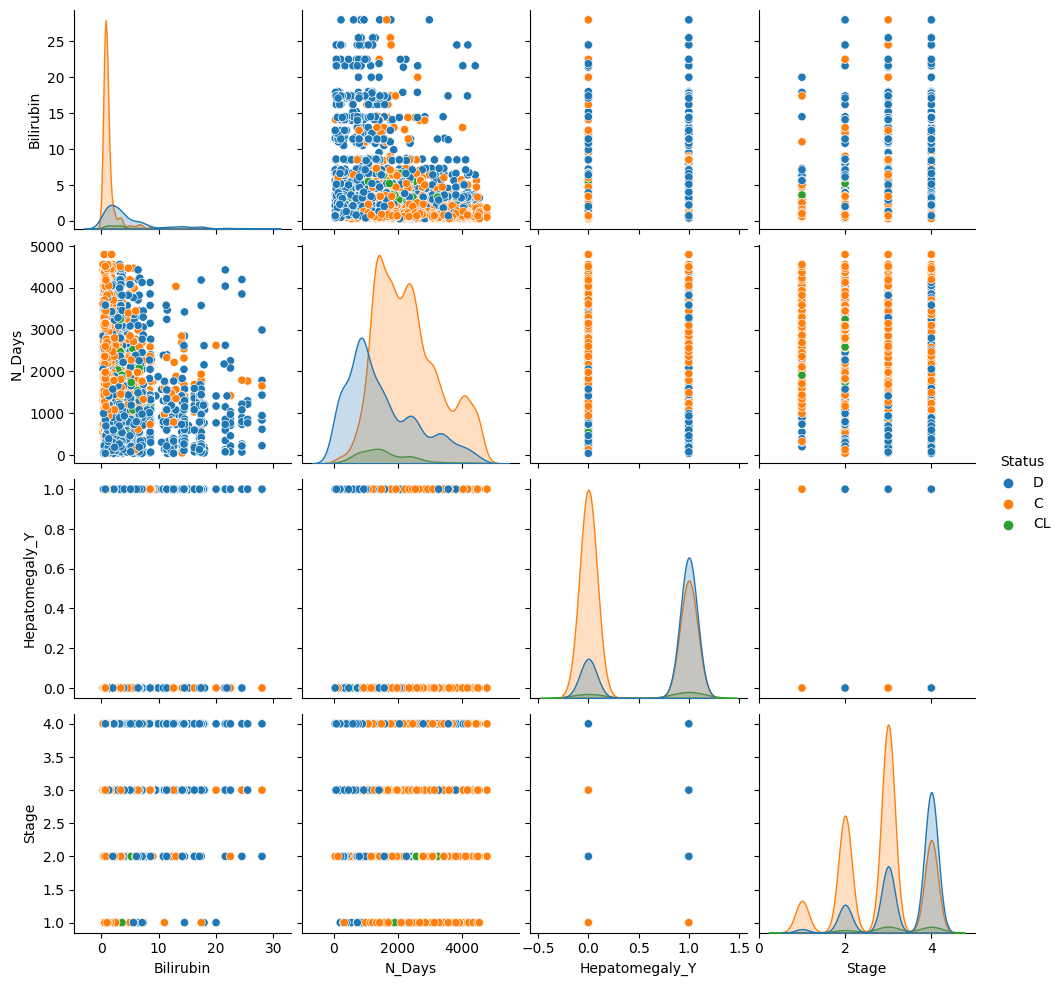

In [ ]:
sns.pairplot(train_csv[['Bilirubin', 'N_Days', 'Hepatomegaly_Y', 'Stage', 'Status']], hue='Status')

In [ ]:
pip install pygwalker

In [ ]:
import pygwalker as pyg

# run the code
pyg.walk(train_csv)

# Data Pre-Processing

## Is the data noisy?

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
# look at alkaline phosphatase
sns.displot(train_csv['Alk_Phos'], bins=100, stat='density')
sns.displot(np.log(train_csv['Alk_Phos']), bins=100, stat='density')

df = pd.DataFrame(np.log(train_csv['Alk_Phos']))
df = std.fit_transform(df[['Alk_Phos']])
sns.displot(df, bins=100, stat='density')

## how to determine whether data is noisy?

In [47]:
# columns need one hot encoding - binary data
train_csv = pd.get_dummies(train_csv, columns=['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Drug'])
train_csv = train_csv.drop(columns=['id'])
test_csv = pd.get_dummies(test_csv, columns=['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Drug'])
# TODO data needs normalization

## Data Normalization

In [48]:
from sklearn.preprocessing import StandardScaler
x_train, y_train = train_csv.loc[:, train_csv.columns != 'Status'], train_csv['Status']

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)

## Solving Class Imbalance

In [49]:
# SMOTE (Synthetic Minority Oversampling Technique)
from imblearn.over_sampling import KMeansSMOTE, SMOTE
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler

kmeans_smote = KMeansSMOTE(sampling_strategy='minority', random_state=42)
smote = SMOTE(random_state=43, sampling_strategy={'CL': 2000})
cc_under = ClusterCentroids(sampling_strategy={'C': 2000, 'D': 2000})
rand_under = RandomUnderSampler(sampling_strategy={'C': 3000, 'D': 2000})
#x_train_kmeans_smote, y_train_kmeans_smote = kmeans_smote.fit_resample(x_train, y_train)
print(x_train.columns)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
x_train_smote, y_train_smote = rand_under.fit_resample(x_train_smote, y_train_smote)
print(y_train.value_counts())
y_train_smote.value_counts()

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Sex_F', 'Sex_M', 'Ascites_N', 'Ascites_Y', 'Hepatomegaly_N',
       'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y', 'Edema_N', 'Edema_S',
       'Edema_Y', 'Drug_D-penicillamine', 'Drug_Placebo'],
      dtype='object')
C     4965
D     2665
CL     275
Name: Status, dtype: int64


C     3000
CL    2000
D     2000
Name: Status, dtype: int64

# Feature Engineering

## ANOVA F-Test Feature Selection


[4.48157522e-001 1.60153217e-221 5.93998443e-076 0.00000000e+000
 1.60475942e-063 9.68488064e-159 7.77087449e-279 2.24283316e-042
 7.86480955e-180 4.36555205e-069 1.90281002e-055 1.85757856e-284
 9.43471134e-221 2.62088695e-030 2.62088695e-030 2.14852501e-137
 2.14852501e-137 2.04263824e-294 2.04263824e-294 1.74922034e-191
 1.74922034e-191 1.71039999e-196 3.42503006e-052 1.10881758e-147
 5.28286052e-002 5.28286052e-002]


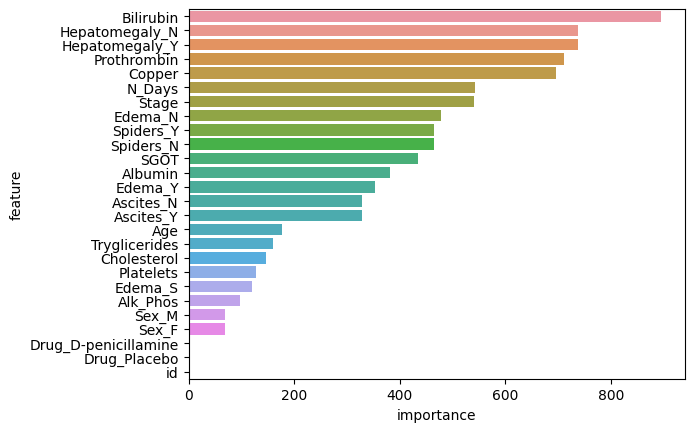

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
x_train_f, y_train_f = train_csv.loc[:, train_csv.columns != 'Status'], train_csv['Status']
anova_ftest = SelectKBest(score_func=f_classif, k='all')
anova_ftest.fit(x_train_f, y_train_f)

ftest_feature_df = pd.DataFrame({
    'feature': x_train_f.columns,
    'importance': anova_ftest.scores_,
    'p_values': anova_ftest.pvalues_}
)

print(anova_ftest.pvalues_)

sorted_ftest_feature_df = ftest_feature_df.sort_values(by='importance', ascending=False)
sns.barplot(data=sorted_ftest_feature_df, y='feature', x='importance')

sorted_ftest_features = list(sorted_ftest_feature_df['feature'])


## LASSO Regularization

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
x_train_log_scaled = x_train_scaled
y_train_log = y_train


log_model = LogisticRegression()
log_model.fit(x_train_log_scaled, y_train_log)
print(log_model.predict(x_train_log_scaled))
# TODO cv scores do not converge for some reason. Maybe not enough data
cv_scores = cross_val_score(log_model, x_train_log_scaled, y_train_log, cv=5)
print("Training accuracy: ", accuracy_score(y_train_log, log_model.predict(x_train_log_scaled)))
print("Cross validation score (CV=5): ", cv_scores.mean())


# Model Selection


## Random Forest

### RF Baseline

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict

x_train_rf, y_train_rf = train_csv.loc[:, train_csv.columns != 'Status'], train_csv['Status']

rf_model = RandomForestClassifier()
print(y_train_rf.value_counts())
rf_model.fit(x_train_rf, y_train_rf)


rf_feature_df = pd.DataFrame({
    'feature': x_train_rf.columns,
    'importance': rf_model.feature_importances_}
)

# sorted_rf_feature_df = rf_feature_df.sort_values(by='importance', ascending=False)
# plt.bar(sorted_rf_feature_df['feature'], sorted_rf_feature_df['importance'])
# plt.xticks(rotation=90)

C     4965
D     2665
CL     275
Name: Status, dtype: int64


Training accuracy:  0.949146110056926
Cross validation accuracy (CV=5):  0.8203668564199873
CV f1 scores (CV=5):  [0.8742078  0.12666667 0.75117739]
CV f1 weighted score (CV=5):  0.8067252120827225


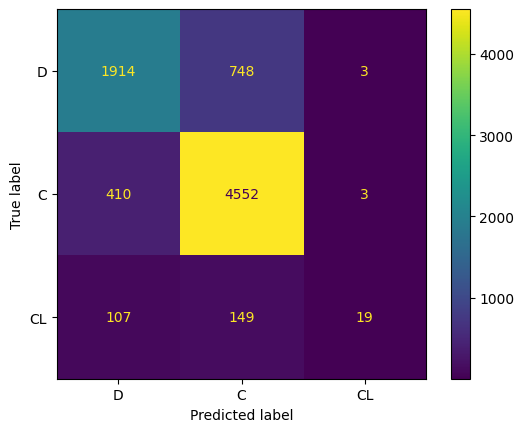

In [45]:
# Compute training and cross validation accuracy using CV predictions
cv_predict = cross_val_predict(rf_model, x_train_rf, y_train_rf, cv=5)

print("Training accuracy: ", accuracy_score(y_train_rf, rf_model.predict(x_train_rf)))
print("Cross validation accuracy (CV=5): ", accuracy_score(y_train_rf, cv_predict))
print("CV f1 scores (CV=5): ", f1_score(y_train_rf, cv_predict, average=None))
print("CV f1 weighted score (CV=5): ", f1_score(y_train_rf, cv_predict, average='weighted'))
# print("Test accuracy: ", )

cm = confusion_matrix(y_train_rf, cv_predict, labels=y_train_rf.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=y_train_rf.unique())
disp.plot()



### RF after over/under sampling

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Sex_F', 'Sex_M', 'Ascites_N', 'Ascites_Y', 'Hepatomegaly_N',
       'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y', 'Edema_N', 'Edema_S',
       'Edema_Y', 'Drug_D-penicillamine', 'Drug_Placebo'],
      dtype='object')
Cross validation accuracy:  0.8537142857142858
CV f1 scores:  [0.85484649 0.93180077 0.77277433]
CV f1 weighted score:  0.853384235702883


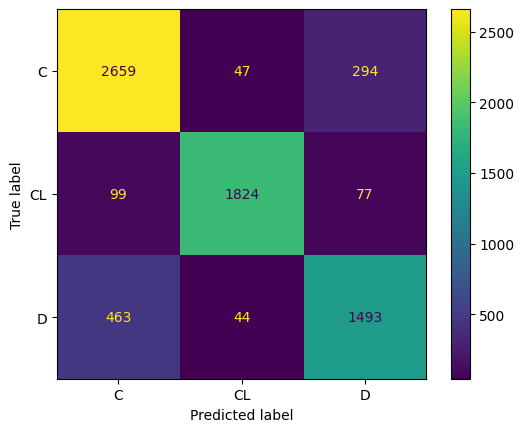

In [51]:
# shows that oversampling minority
print(x_train_smote.columns)
rf_model_smote = rf_model.fit(x_train_smote, y_train_smote)

# generate CV predictions, not just score
cv_predict = cross_val_predict(rf_model_smote, x_train_smote, y_train_smote, cv=5)

cv_f1_scores(y_train_smote, cv_predict)

confusion_matrix_viz(y_train_smote, cv_predict)

# Algorithm better predicts CL labels, but worse at D & C


In [ ]:
cv_f1_scores(y_test, cv_predict)

### RF after RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 600, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_model_random = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                     param_distributions=random_grid,
                                     n_iter=10, cv=4, verbose=2, random_state=42,
                                     n_jobs=-1)
rf_model_random.fit(x_train_smote, y_train_smote)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600]},
                   random_state=42, verbose=2)

In [ ]:
print(rf_model_random.best_estimator_)
print(rf_model_random.best_score_)

RandomForestClassifier(bootstrap=False, max_depth=90, max_features='auto',
                       min_samples_split=5, n_estimators=400)
0.8537142857142858


### RF after GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = [400]
# Maximum number of levels in tree
max_depth = [70, 90, 100]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8]
# Method of selecting samples for training each tree
bootstrap = [False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}

rf_model_grid = GridSearchCV(estimator=RandomForestClassifier(),
                                     param_grid=random_grid, cv=4, verbose=2,
                                     n_jobs=-1)
rf_model_grid.fit(x_train_smote, y_train_smote)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [70, 90, 100],
                         'min_samples_split': [2, 5, 8],
                         'n_estimators': [400]},
             verbose=2)

In [ ]:
print(rf_model_grid.best_estimator_)
print(rf_model_grid.best_score_)
cv_predict = cross_val_predict(rf_model_grid.best_estimator_, x_train_smote, y_train_smote, cv=5)
f1_score(y_train_smote, cv_predict, average='weighted')

RandomForestClassifier(bootstrap=False, max_depth=90, n_estimators=400)
0.8574285714285714


0.8570436226506112

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
x_train_log_scaled = x_train_scaled
y_train_log = y_train


log_model = LogisticRegression()
log_model.fit(x_train_log_scaled, y_train_log)
print(log_model.predict(x_train_log_scaled))
# TODO cv scores do not converge for some reason. Maybe not enough data
cv_scores = cross_val_score(log_model, x_train_log_scaled, y_train_log, cv=5)
print("Training accuracy: ", accuracy_score(y_train_log, log_model.predict(x_train_log_scaled)))
print("Cross validation score (CV=5): ", cv_scores.mean())


['C' 'C' 'D' ... 'D' 'C' 'C']
Training accuracy:  0.7969639468690702
Cross validation score (CV=5):  0.7941808981657179


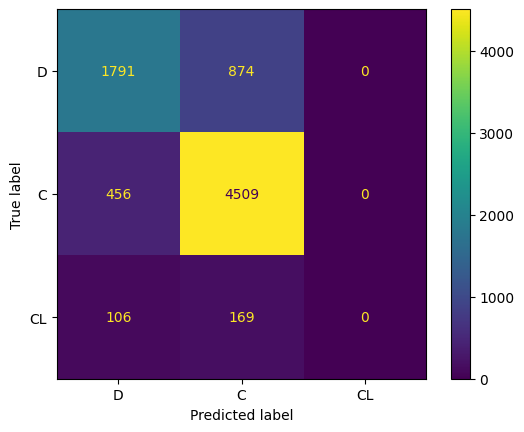

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_log, log_model.predict(x_train_log_scaled), labels=y_train_log.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=y_train_log.unique())
disp.plot()

# Performance Analysis

## Helper Functions

In [9]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict


## helper function to compute cross validation accuracy, f1 scores
# y_true : true labels from training/ test data
# y_pred : a series of predictions resulting from cross_val_predict or test data
def cv_f1_scores(y_true, y_pred):
  print("Cross validation accuracy: ", accuracy_score(y_true, y_pred))
  print("CV f1 scores: ", f1_score(y_true, y_pred, average=None))
  print("CV f1 weighted score: ", f1_score(y_true, y_pred, average='weighted'))


## helper function to display confution matrix
# y_true : true labels from training/ test data
# y_pred : a series of predictions resulting from cross_val_predict or test data
def confusion_matrix_viz(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=y_true.unique())
  disp.plot()

## Test Submission

In [67]:
def test_data(ml):
  global test_csv
  id, c_pred, d_pred, cl_pred = [[] for i in range(4)]
  id = list(test_csv['id'])
  x_test = test_csv.drop(columns=['id'])
  labels = ['Status_C', 'Status_CL', 'Status_D']
  pred = ml.predict_proba(x_test)
  result = pd.DataFrame(pred, columns=labels)
  result.insert(0, 'id', id)
  result.columns = ['id', 'Status_C', 'Status_CL', 'Status_D']
  result = result.set_index('id')
  print(len(result))
  result.to_csv('kaggle_cirrhosis_sub_1.csv')

test_data(rf_model_smote)


5271


#Prediction Pipeline

In [ ]:
# Goal: Predict CL first, then C or D

## Create training data that upsamples CL, downsamples D & C,
## then relabel as 1 (CL) or 0 (D or C)

# SMOTE (Synthetic Minority Oversampling Technique)
from imblearn.over_sampling import KMeansSMOTE, SMOTE
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict


def training_data_pipe1():
  smote = SMOTE(random_state=43, sampling_strategy={'CL': 2000})
  rand_under = RandomUnderSampler(sampling_strategy={'C': 1000, 'D': 1000})
  #x_train_kmeans_smote, y_train_kmeans_smote = kmeans_smote.fit_resample(x_train, y_train)
  x_train_smote_pipe1, y_train_smote_pipe1 = smote.fit_resample(x_train, y_train)
  x_train_smote_pipe1, y_train_smote_pipe1 = rand_under.fit_resample(x_train_smote_pipe1, y_train_smote_pipe1)

  y_train_smote_pipe1 = y_train_smote_pipe1.replace('C', 0)
  y_train_smote_pipe1 = y_train_smote_pipe1.replace('D', 0)
  y_train_smote_pipe1 = y_train_smote_pipe1.replace('CL', 1)
  print(y_train_smote_pipe1.value_counts()) # should be 1(CL): 2000, 0 (D or C): 2000
  return x_train_smote_pipe1, y_train_smote_pipe1

def rf_classify(x, y):
  rf_model = RandomForestClassifier()
  rf_model.fit(x, y)
  print("Training accuracy: ", accuracy_score(y, rf_model.predict(x)))
  cv_predict = cross_val_predict(rf_model, x, y, cv=5)

  print("Training accuracy: ", accuracy_score(y, rf_model.predict(x)))
  print("Cross validation accuracy (CV=5): ", accuracy_score(y, cv_predict))
  print("CV f1 scores (CV=5): ", f1_score(y, cv_predict, average=None))
  print("CV f1 weighted score (CV=5): ", f1_score(y, cv_predict, average='weighted'))





x, y = training_data_pipe1()
rf_classify(x, y)


0    2000
1    2000
Name: Status, dtype: int64
Training accuracy:  1.0
Training accuracy:  1.0
Cross validation accuracy (CV=5):  0.94025
CV f1 scores (CV=5):  [0.94123433 0.93923214]
CV f1 weighted score (CV=5):  0.9402332316860649
